# Logistic Regression
Logistic regression is a type of statistical analysis used to predict the probability of an event occurring based on certain independent variables. In logistic regression, a logistic function is used to model the probability of a certain class or event existing such as a customer buying a product or a patient having a disease. The independent variables are then used to predict the probability of the event occurring.

## with Regularisation

Logistic regression with gradient descent is an effective and efficient algorithm that can be used to solve a wide variety of classification problems, from binary (yes/no) to multi-class. It is a supervised learning algorithm that uses a sigmoid or logistic function to map the inputs to the class labels. Gradient descent is used to minimize the cost function associated with logistic regression, which is based on the sum of the squared errors of the predicted values. This allows the algorithm to learn the weights associated with the features and to reduce the error in its prediction. The combination of logistic regression and gradient descent is a powerful tool that can be used to build accurate models for predicting the outcomes of various kinds of data.

In [1]:
# saves you having to use print as all exposed variables are printed in the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ds_discovery import SyntheticBuilder, ModelsBuilder, Commons
from sklearn.model_selection import train_test_split

%matplotlib inline

## Synthetic Binary Classification


In [3]:
sb = SyntheticBuilder.from_memory()

In [4]:
# build a sample dataframe
sample = 1_000
df = sb.tools.frame_starter(sample)
df['bias'] = sb.tools.get_noise(size=sample)

# Modify the features for classification to change the features
df = sb.tools.model_synthetic_classification(canonical=df, n_features=3, n_informative=3, n_redundant=0, seed=42)


In [5]:
canonical = df.copy().drop('target', axis=1)

## Split (test, train)

In [6]:
# select X, Y and convert to numpy matrix
X = df.drop('target', axis=1).to_numpy()
y = df['target'].to_numpy().astype(np.int32)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

## Model (logistic regression)

### Sigmoid function
$$ \sigma( w^T x + b) $$

### forward (probability of y given x)
$$ \frac{1}{1 + e^{-(w^T x + b)}} $$


In [8]:
# randomly initialize the weights
D = X_train.shape[1]
w = np.random.randn(D)
b = 0

In [9]:
# predictions
def sigmoid(a):
    return 1 / (1 + np.exp(-a))

# forward gate
def forward(X, w, b):
    return sigmoid(X.dot(w) + b)

## Performance

### Log likelyhood
$$ \mathcal{L} = \sum_{i=1}^{N}t_i\log(n_i)+(1-t_i)\log(1-n_i) $$

### Cross-entropy error
$$ \mathcal{J} = -\sum_{i=1}^N t_i \log(n_i) + (1-t_i) \log(1-n_i) $$

note: Cross-entropy error is just the negative of Log likelyhood therefore raising the Log likelyhood is like lowering the Cross-entropy error

In [10]:
# classification rate: target against prediction
def classification_rate(y, P):
    return np.mean(y == P)

# cross entropy loss: target agaist P of y=1 given X
def cross_entropy(y, Py):
    return -np.mean(y * np.log(Py) - (1 - y) * np.log(1 - Py))

## Model Train

### Gradient Decent with respect to weight
$$ \frac{\delta J}{\delta w} = \sum_{n=1}^{N} \left( y_n - t_n \right) x_n \quad \Leftrightarrow \quad X_T \left( Y - T \right) $$

### Gradient Decent with respect to bias
$$ \frac{\delta J}{\delta w_0} = \sum_{n=1}^{N} (y_n - t_n)x_{n0} = \sum_{n=1}^{N} (y_n - t_n) \quad \Leftrightarrow \quad \sum \left( Y - T \right) $$



In [11]:
train_cost = []
test_cost = []
final_w = None
final_b = None

# adjust to model to improve performance and cost
learning_rate = 0.0001
epochs = 1_000

for i in range(epochs):
    
    # predict
    Py_train = forward(X_train, w, b)
    Py_test = forward(X_test, w, b)
    
    # accumulate costs
    c_train = cross_entropy(y_train, Py_train)
    c_test = cross_entropy(y_test, Py_test)
    
    # accumulate costs in a list
    train_cost.append(c_train)
    test_cost.append(c_test)
    
    # update the weight with learning rate and gradient decent
    w -= learning_rate * X_train.T.dot(Py_train - y_train)
    b -= learning_rate * (Py_train - y_train).sum()
    
    if i == epochs-1:
        final_w = w
        final_b = b
    
    

In [12]:
# test our classification rate. Round the prob y to 1 and 0
acc_train = classification_rate(y_train, np.around(Py_train))
print(f"Train classification rate {acc_train}")

acc_test = classification_rate(y_test, np.around(Py_test))
print(f"Test classification rate {acc_test}")


Train classification rate 0.9185714285714286
Test classification rate 0.89


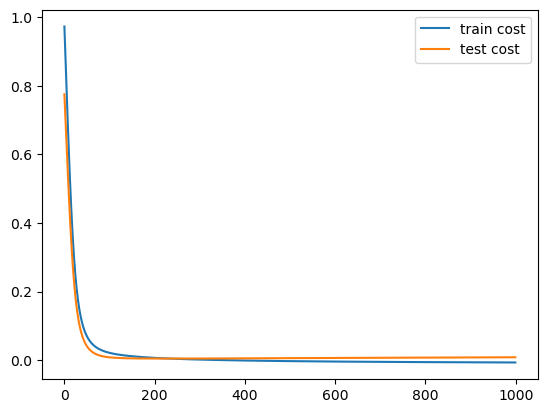

In [13]:
# plot our cost error
plt.plot(train_cost, label="train cost")
plt.plot(test_cost, label="test cost")
plt.legend();

In [14]:
print(f"weights: {final_w}")
print(f"\nbias: {final_b}")

weights: [-0.60127439  3.1320576   0.74953463  0.40254778]

bias: 0.7205716603601828


## Model Predict
As an example let's extend our ModelsBuilder to includes a new bespoke model as part of our intent actions.

In [15]:
from ds_discovery.intent.models_intent import ModelsIntentModel, Commons
from ds_discovery.managers.models_property_manager import ModelsPropertyManager
from ds_discovery import ModelsBuilder

### Extending our three classes

In [16]:
class CustomModel(ModelsBuilder):

    @classmethod
    def from_uri(cls, task_name: str, uri_pm_path: str, creator: str, uri_pm_repo: str=None,
                 pm_file_type: str=None, pm_module: str=None, pm_handler: str=None, pm_kwargs: dict=None,
                 default_save=None, reset_templates: bool=None, template_path: str=None, template_module: str=None,
                 template_source_handler: str=None, template_persist_handler: str=None, align_connectors: bool=None,
                 default_save_intent: bool=None, default_intent_level: bool=None, order_next_available: bool=None,
                 default_replace_intent: bool=None, has_contract: bool=None):
        pm_file_type = pm_file_type if isinstance(pm_file_type, str) else 'json'
        pm_module = pm_module if isinstance(pm_module, str) else cls.DEFAULT_MODULE
        pm_handler = pm_handler if isinstance(pm_handler, str) else cls.DEFAULT_PERSIST_HANDLER
        _pm = CustomModelPropertyManager(task_name=task_name, creator=creator)
        _intent_model = CustomModelIntentModel(property_manager=_pm, default_save_intent=default_save_intent,
                                               default_intent_level=default_intent_level,
                                               order_next_available=order_next_available,
                                               default_replace_intent=default_replace_intent)
        super()._init_properties(property_manager=_pm, uri_pm_path=uri_pm_path, default_save=default_save,
                                 uri_pm_repo=uri_pm_repo, pm_file_type=pm_file_type, pm_module=pm_module,
                                 pm_handler=pm_handler, pm_kwargs=pm_kwargs, has_contract=has_contract)
        return cls(property_manager=_pm, intent_model=_intent_model, default_save=default_save,
                   reset_templates=reset_templates, template_path=template_path, template_module=template_module,
                   template_source_handler=template_source_handler, template_persist_handler=template_persist_handler,
                   align_connectors=align_connectors)


In [17]:
class CustomModelPropertyManager(ModelsPropertyManager):
    
    def __init__(self, task_name: str, creator: str):
        root_keys = []
        knowledge_keys = []
        super().__init__(task_name=task_name, root_keys=root_keys, knowledge_keys=knowledge_keys, creator=creator)


In [18]:
class CustomLogisticRegression(object):
    
    def fit(X_train, weight, bias):
        pass
    
    def predict(canonical):
        pass
    

In [19]:
class CustomModelIntentModel(ModelsIntentModel):

    def custom_classifier(self, canonical, weight, bias, save_intent: bool=None, intent_level: [int, str]=None, 
                          intent_order: int=None, replace_intent: bool=None, remove_duplicates: bool=None):
        
        # resolve intent persist options
        self._set_intend_signature(self._intent_builder(method=inspect.currentframe().f_code.co_name, params=locals()),
                                   intent_level=intent_level, intent_order=intent_order, replace_intent=replace_intent,
                                   remove_duplicates=remove_duplicates, save_intent=save_intent)
        
        X = canonical.to_numpy()
        # predictions
        def sigmoid(a):
            return 1 / (1 + np.exp(-a))

        y = sigmoid(X.dot(w) + b)
        pred = np.around(y, 0)
        pred = pd.DataFrame(pred, columns=['predict'])
        return pred.join(canonical, how='inner')
        

### create model instance

In [20]:
ml = CustomModel.from_env('extender', has_contract=False)

taking a view of our intent actions we can see our new ``custom_classifier`` has been added

In [21]:
ml.intent_model.__dir__()

['PREDICT_INTENT_LEVEL',
 'TRAIN_INTENT_LEVEL',
 'custom_classifier',
 'label_predict',
 'run_intent_pipeline']

### set trained model

In [22]:
weight = [-0.19766923,0.12403557,-0.70134031,-0.7958989,1.34681211,-0.39506922,
          0.06584865,0.11578781,-0.49344841,-0.60231951,-1.29599324]
bias = -0.5506100458838631

### get custom prediction

In [23]:
result = ml.intent_model.custom_classifier(canonical, weight=weight, bias=bias)

NameError: name 'inspect' is not defined

In [ ]:
classification_rate(y, result['predict'].to_numpy())